# Финальное задание курса

В итоговом задании курса мы предлагаем вам решить задачу регрессии - по характеристикам поездок на такси в Нью-Йорке научиться определять их стоимость.

В задании две части:

* первая часть - обычная. Так устроены все ноутбуки с домашними заданиями в курсе. Мы что-то просим - вы делаете. Задания этой части как обычно проверяются тестами на Stepik

* вторая часть - творческая. В этой части мы даем вам лишь идеи того, что можно сделать, а все остальное - на вас. Это задание проверяется в виде текстового отчета (подробности смотрите в описании второй части задания)

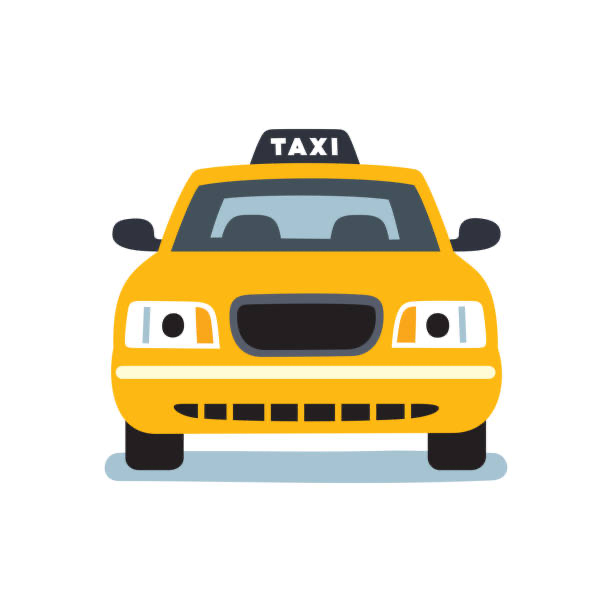

# Часть 1

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Считаем данные

In [2]:
df = pd.read_csv("https://www.dropbox.com/s/glmbcyopi24m2ni/final_project_data.csv?dl=1")

df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2011-11-23 14:36:35.0000003,2011-11-23 14:36:35 UTC,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5
1,2013-09-14 21:40:00.00000016,2013-09-14 21:40:00 UTC,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5
2,2012-04-30 18:13:19.0000002,2012-04-30 18:13:19 UTC,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5
3,2010-10-22 15:03:47.0000001,2010-10-22 15:03:47 UTC,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5
4,2011-02-18 18:08:16.0000002,2011-02-18 18:08:16 UTC,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1


## Исследование данных

### Quiz

Сколько строк в таблице df?

In [5]:
df.shape[0]

615962

### Quiz

Есть ли пропущенные значения в таблице? В скольких столбцах есть пропуски?

In [4]:
df.isna().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      1
dropoff_longitude    3
dropoff_latitude     3
passenger_count      1
fare_amount          1
dtype: int64

### Quiz

Удалите строки с пропущенными значениями из таблицы. Сколько строк осталось в таблице?

In [7]:
df.dropna(inplace=True)
df.shape[0]

615959

Удалите из данных колонку `key`, так как в ней дублируется информация из `pickup_datetime`

In [8]:
df.drop(columns=["key"], inplace=True)

Обработайте колонку `pickup_datetime`. Выделите из нее 4 новых столбца:

* `year` - год поездки
* `month` - месяц поездки
* `day` - день поездки
* `hour` - час поездки. Час вычисляйте так: если до следующего часа осталось меньше 30 минут (на секунды не смотрим), что час округляете до следующего.

Пример: 14:18:20 -> 14 часов, 17:48:29 -> 18 часов

Затем удалите столбец `pickup_datetime`.



In [12]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Создаем новые столбцы
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day

# Округляем час по правилу
minutes = df['pickup_datetime'].dt.minute
df['hour'] = df['pickup_datetime'].dt.hour + (minutes >= 30).astype(int)
df['hour'] = df['hour'] % 24  # чтобы после 23:30 не получилось 24

# Удаляем исходный столбец
df.drop(columns=['pickup_datetime'], inplace=True)

## Вопросы по данным

### Quiz

В какие годы совершались поездки?

In [15]:
df['year'].unique()

array([2011, 2013, 2012, 2010, 2009, 2014, 2015])

### Quiz

В какой час было совершено больше всего поездок?

In [20]:
df['hour'].mode()

0    19
Name: hour, dtype: int32

### Quiz

В какой сезон (зима, весна, лето, осень) было совершено наименьшее число поездок?

In [36]:
season_counts = df['month'].apply(lambda month: 'зима' if month in [12, 1, 2] else 'весна' if month in [3, 4, 5] else 'лето' if month in [6, 7, 8] else 'осень').value_counts()
season_counts.idxmin()

'осень'

Постройте scatter plot в осях `pickup_latitude` и `pickup_longitude`

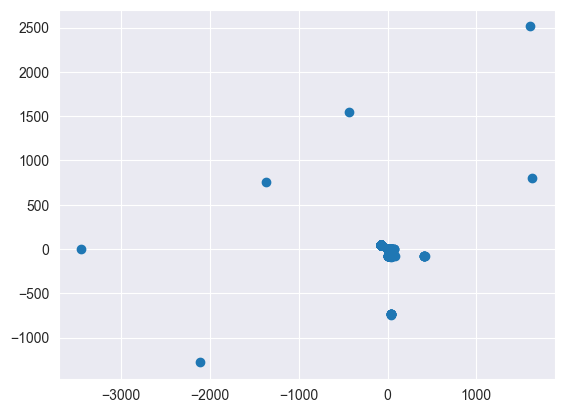

In [38]:
plt.scatter(df.pickup_latitude, df.pickup_longitude)
plt.show()

### Quiz

Постройте ящик с усами boxplot для `pickup_longitude`. Есть ли на визуализации выбросы? (отдельные точки)

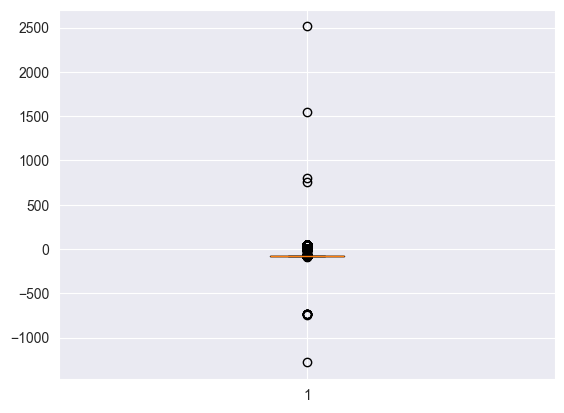

In [39]:
plt.boxplot(df.pickup_longitude)
plt.show()

### Quiz

Чему равна медиана `pickup_longitude`? Ответ округлите до тысячных.

In [40]:
df.pickup_longitude.median()

-73.981803

Постройте гистограмму распределения признака `hour`.

(array([ 64117.,  20229.,  13922.,  72430.,  55668.,  60051.,  88914.,
         61305.,  76148., 103175.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

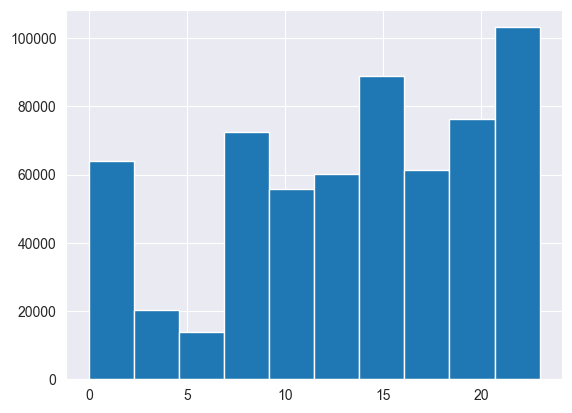

In [41]:
plt.hist(df['hour'])

## Построение baseline-модели

Разбейте `df` на матрицу объект-признак `X` и вектор с целевой переменной `y`. Целевая переменная - столбец `fare_amount`.

In [42]:
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

Разбейте данные на тренировочную и тестовую части с помощью train_test_split.

Тестовая часть - 25% всех данных, `random_state=42`.

Сколько строк в матрице `X_train`?

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((461969, 9), (153990, 9), (461969,), (153990,))

### Quiz

Обучите решающее дерево глубины 3 на тренировочных данных и вычислите ошибку $R^2$ на тесте. Ответ округлите до сотых.

Зафиксируйте у дерева `random_state=42`.

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

tree = DecisionTreeRegressor(random_state=42, max_depth=3)
tree.fit(X_train, y_train)
r2_score(y_test, tree.predict(X_test))

0.4998349394485503

### Quiz

Постройте гистограмму важности признаков.

Какой признак имеет наибольший вес?

(array([7., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.        , 0.06372631, 0.12745263, 0.19117894, 0.25490526,
        0.31863157, 0.38235789, 0.4460842 , 0.50981052, 0.57353683,
        0.63726315]),
 <BarContainer object of 10 artists>)

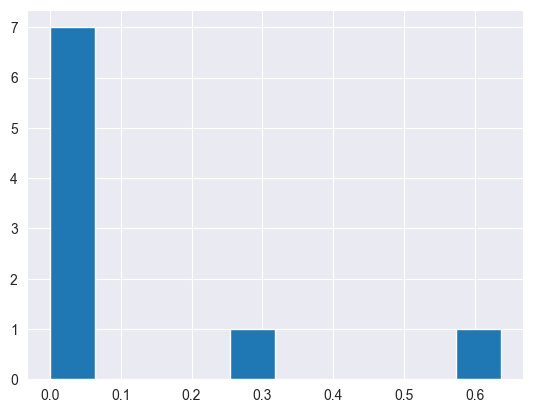

In [46]:
plt.hist(tree.feature_importances_)

In [49]:
X_train.columns[tree.feature_importances_.argmax()]

'dropoff_longitude'

## Улучшение модели

### Quiz

Постройте гистограмму распределения целевой переменной `y`, укажите параметр `bins=100`.

Является ли распределение нормальным?

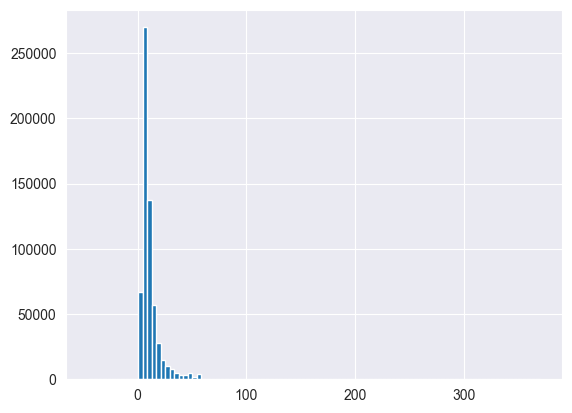

In [52]:
plt.hist(y, bins=100)
plt.show()

Замените все значения $y$, меньшие 0, на 0.

Сделайте преобразование целевой переменной по правилу $y_{new} = np.log1p(y)$

Заново разбейте данные на тренировочную и тестовую часть по тем же правилам, что и раньше, но теперь используйте `X` и `y_new`.

In [53]:
y_new = np.where(y < 0, 0, y)
y_new = np.log1p(y_new)
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.25, random_state=42)

### Quiz

Заново обучите решающее дерево глубины 3 с `random_state=42` на тренировочных данных и вычислите $R^2$ на тесте. Ответ округлите до сотых.

Перед вычислением $R^2$ сделайте обратное преобразование от прогноза: `np.expm1(pred)` и от `y_test`.

**Важно:** дальше мы будем работать с преобразованной целевой переменной, поэтому при вычислении $R^2$ во всех заданиях ниже делайте обратное преобразование.

In [54]:
tree = DecisionTreeRegressor(random_state=42, max_depth=3)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)

r2_score(np.expm1(y_test), np.expm1(pred))

0.4434601265690873

### Quiz


Подберите по кросс-валидации на тренировочных данных глубину дерева в диапазоне от 3 до 10 включительно с шагом 1 (`random_state=42`).

`cv=3, scoring=r2`

Затем примените модель с оптимальной глубиной на тесте и вычислите $R^2$. Ответ округлите до сотых.

Перед вычислением $R^2$ не забудьте (как и дальше) делать преобразование `np.expm1`

In [57]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': np.arange(3, 11, 1),
    'random_state': [42],
}

cv = GridSearchCV(estimator=tree, param_grid=params, cv=3, scoring='r2')
cv.fit(X_train, y_train)
cv.best_params_

{'max_depth': 10, 'random_state': 42}

In [58]:
pred = cv.best_estimator_.predict(X_test)
r2_score(np.expm1(y_test), np.expm1(pred))

0.6881941477032822

## Усложнение пайплайна

Создайте pipeline, в котором сначала извлеките полиномиальные признаки степени 2 из данных, а затем обучите решающее дерево глубины 3 с `random_state=42`.

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

p1 = Pipeline([
    ('features', PolynomialFeatures(degree=2)),
    ('model', DecisionTreeRegressor(max_depth=3, random_state=42))
])

### Quiz

Обучите pipeline на тренировочных данных, сделайте прогноз на тесте и вычислите $R^2$. Ответ округлите до сотых.

In [60]:
p1.fit(X_train, y_train)
pred = p1.predict(X_test)
r2_score(np.expm1(y_test), np.expm1(pred))

0.4173231422216578

При помощи GridSearchCV с теми же гиперпараметрами, что и раньше, подберите глубину дерева внутри пайплайна в диапазоне от 3 до 10 включительно с шагом 1.

In [64]:
params = {
    'model__max_depth': np.arange(3, 11, 1),
}

cv = GridSearchCV(estimator=p1, param_grid=params, cv=3, scoring='r2')
cv.fit(X_train, y_train)
cv.best_params_

{'model__max_depth': 10}

### Quiz

Выведите $R^2$ лучшего результата на тесте. Ответ округлите до сотых.

In [67]:
X_test

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
157317,-73.957497,40.773888,-73.948975,40.773075,1.0,2015,2,24,20
196960,-73.978980,40.772448,-74.003533,40.747260,1.0,2012,4,28,0
464532,-73.983977,40.729296,-73.976709,40.732457,1.0,2013,2,4,17
412659,-73.960170,40.804518,-73.982100,40.764610,1.0,2011,12,18,2
227464,-73.981359,40.780897,-73.981001,40.788972,1.0,2011,1,17,18
...,...,...,...,...,...,...,...,...,...
197443,-73.776920,40.645172,-73.987117,40.722742,1.0,2011,11,23,7
420580,-73.872808,40.774043,-73.862957,40.734782,1.0,2012,5,10,7
567483,-73.971305,40.795490,-73.964275,40.807362,5.0,2013,12,5,18
601951,-73.863300,40.769413,-73.863300,40.769413,1.0,2011,9,11,7


In [65]:
pred = cv.best_estimator_.predict(X_test)
r2_score(np.expm1(y_test), np.expm1(pred))

0.7141308827831072

## Feature selection

Добавьте в предыдущий пайплайн:
* после добавления полиномиальных признаков - StandardScaler
* затем - снижение размерности при помощи метода `SelectFromModel` с моделью `Ridge` с гиперпараметрами по умолчанию.

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge

p2 = Pipeline([
    ('features', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(Ridge())),
    ('model', DecisionTreeRegressor(random_state=42))
])

params = {
    'model__max_depth': np.arange(3, 11, 1),
}

cv = GridSearchCV(estimator=p2, param_grid=params, cv=3, scoring='r2')
cv.fit(X_train, y_train)

pred = cv.best_estimator_.predict(X_test)
r2_score(np.expm1(y_test), np.expm1(pred))

0.6698534940345506

Обучите пайплайн на тренировочных данных, сделайте прогноз на тесте и вычислите для него $R^2$.

In [ ]:
# ваш код здесь

Подберите глубину решающего дерева в пайплайне, в том же диапазоне и теми же гиперпараметрами GridSearch, что и в предыдущих заданиях.

Вычислите $R^2$ на тестовых данных, ответ округлите до сотых.

In [ ]:
# ваш код здесь

In [ ]:
# ваш код здесь

### Quiz

Удалось ли при помощи пайплайна с отбором признаков улучшить результат предыдущей лучшей модели?

## Кодирование категориальных признаков

Признаки `month`, `day`, `hour` - категориальные (подумайте почему!)

Поэтому их можно попробовать закодировать.

Попробуем подход: группировка значений признака + дальнейшая OneHot-кодировка.

* Создайте колонки `winter`, `spring`, `summer`, `autumn` - в каждую из которых пишите 1, если месяц относится к сезону, и 0 иначе.

* Создайте колонки `start_month`, `middle_month`, `end_month` - в каждую колонку пишите 1, если день относится к началу месяца (1-10 число), середине месяца (11-20 число), концу месяца (от 21 числа), и 0 иначе.

* Создайте колонки `night`, `morning`, `day`, `evening` по аналогии. Если час - от 23 до 5, то это `night`, от 6 до 11 - `morning`, от 12 до 16 - `day`, от 17 до 22 - `evening`.

После создания новых колонок удалите колонки `month`, `day`, `hour`.

P.S. Отдельно делайте преобразования для X_train и для X_test, чтобы заново не разбивать данные.

In [70]:
def preprocess_time_features(df):
    # Сезоны
    df['winter'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)
    df['spring'] = df['month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)
    df['summer'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
    df['autumn'] = df['month'].apply(lambda x: 1 if x in [9, 10, 11] else 0)

    # Части месяца
    df['start_month'] = df['day'].apply(lambda x: 1 if 1 <= x <= 10 else 0)
    df['middle_month'] = df['day'].apply(lambda x: 1 if 11 <= x <= 20 else 0)
    df['end_month'] = df['day'].apply(lambda x: 1 if x >= 21 else 0)

    # Время суток
    df['night'] = df['hour'].apply(lambda x: 1 if x in [23, 0, 1, 2, 3, 4, 5] else 0)
    df['morning'] = df['hour'].apply(lambda x: 1 if 6 <= x <= 11 else 0)
    df['day'] = df['hour'].apply(lambda x: 1 if 12 <= x <= 16 else 0)
    df['evening'] = df['hour'].apply(lambda x: 1 if 17 <= x <= 22 else 0)

    # Удаляем исходные признаки
    df.drop(columns=['month', 'day', 'hour'], inplace=True)

    return df

# Применяем к X_train и X_test
X_train = preprocess_time_features(X_train)
X_test = preprocess_time_features(X_test)

### Quiz

На сколько признаков стало больше в матрице-объект признак после добавления закодированных категориальных столбцов и удаления исходных категориальных столбцов?

Подберите при помощи GridSearch с теми же гиперпараметрами, что и выше, оптимальную глубину дерева в диапазоне от 3 до 10 включительно (с шагом 1). У дерева `random_state=42`.

In [82]:
params = {
    'model__max_depth': np.arange(3, 11, 1),
}

cv = GridSearchCV(estimator=p2, param_grid=params, cv=3, scoring='r2')
cv.fit(X_train, y_train)
pred = cv.best_estimator_.predict(X_test)
r2_score(np.expm1(y_test), np.expm1(pred))

0.6634343948690431

Постройте гистограмму важности признаков для полученной модели (лучшей по GridSearch).

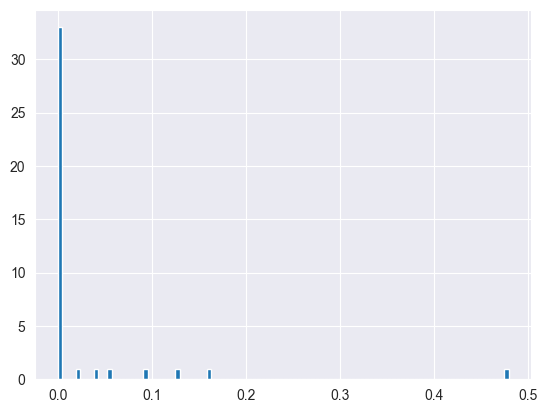

In [83]:
plt.hist(cv.best_estimator_.named_steps['model'].feature_importances_, bins=100)
plt.show()

In [84]:
X_train.columns[cv.best_estimator_.named_steps['model'].feature_importances_.argmax()]

'start_month'

### Quiz

Какой из признаков, связанных с датой поездки, самый важный для модели?

## Кластеризация и визуализация

Оставьте только те строчки в таблице df (после удаления пропусков), для которых выполнены оба условия:

* `dropoff_latitude` $\in (39;41)$
* `dropoff_longitude` $\in (-75;-72)$

### Quiz

Сколько строк осталось в таблице?

In [ ]:
X_train = X_train[
    (X_train['dropoff_latitude'] > 39) & (X_train['dropoff_latitude'] < 41) &
    (X_train['dropoff_longitude'] > -75) & (X_train['dropoff_longitude'] < -72)
]
X_test = X_test[
    (X_test['dropoff_latitude'] > 39) & (X_test['dropoff_latitude'] < 41) &
    (X_test['dropoff_longitude'] > -75) & (X_test['dropoff_longitude'] < -72)
]

In [88]:
df = df[
    (df['dropoff_latitude'] > 39) & (df['dropoff_latitude'] < 41) &
    (df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -72)
]
df.shape

(603729, 11)

Разбейте все поездки по признакам `dropoff_latitude`, `dropoff_longitude` на 5 кластеров.

Используйте kmeans c `random_state=42`.

Визуализируйте поездки из таблицы df в осях `dropoff_latitude`, `dropoff_longitude` - покрасьте точки в цвета, соответствующие кластерам.

C:\Temp\ipykernel_23564\2545675664.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(coords)


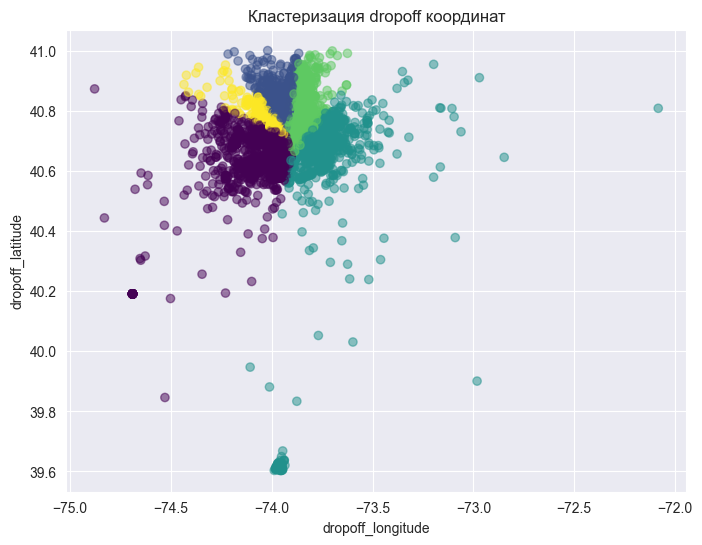

In [92]:
from sklearn.cluster import KMeans

coords = df[['dropoff_latitude', 'dropoff_longitude']]

# Инициализация и обучение kmeans
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(coords)

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(
    df['dropoff_longitude'], df['dropoff_latitude'],
    c=df['cluster'], cmap='viridis', alpha=0.5
)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.title('Кластеризация dropoff координат')
plt.show()

### Quiz

Для каждого кластера вычислите среднюю стоимость поездки.

Чему равна самая большая средняя стоимость поездки по кластерам? Ответ округлите до целого числа.

In [95]:
cluster_fare_means = df.groupby('cluster')['fare_amount'].mean()

Отдельно нарисуйте кластер с наибольшей средней стоимостью поездки. В нем выделяется два островка.

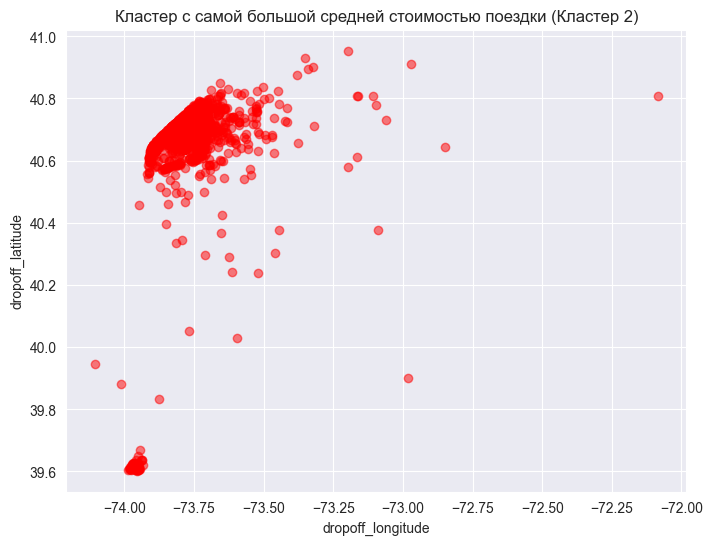

In [96]:
import matplotlib.pyplot as plt

# Найдем кластер с наибольшей средней стоимостью
cluster_with_max_fare = cluster_fare_means.idxmax()

# Отфильтруем данные для этого кластера
df_max_fare_cluster = df[df['cluster'] == cluster_with_max_fare]

# Построим график для этого кластера
plt.figure(figsize=(8, 6))
plt.scatter(
    df_max_fare_cluster['dropoff_longitude'],
    df_max_fare_cluster['dropoff_latitude'],
    alpha=0.5,
    color='red'
)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.title(f'Кластер с самой большой средней стоимостью поездки (Кластер {cluster_with_max_fare})')
plt.show()

### Quiz

Кластеризуйте точки этого кластера при помощи DBSCAN с гиперпараметрами `eps`=0.15, `min_samples`=10.

Нарисуйте результат.

Вычислите координаты центра (среднее арифметрическое) меньшего кластера.

В ответе укажите `dropoff_latitude`, округленную до тысячных.

C:\Temp\ipykernel_23564\855690984.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max_fare_cluster['dbscan_cluster'] = labels


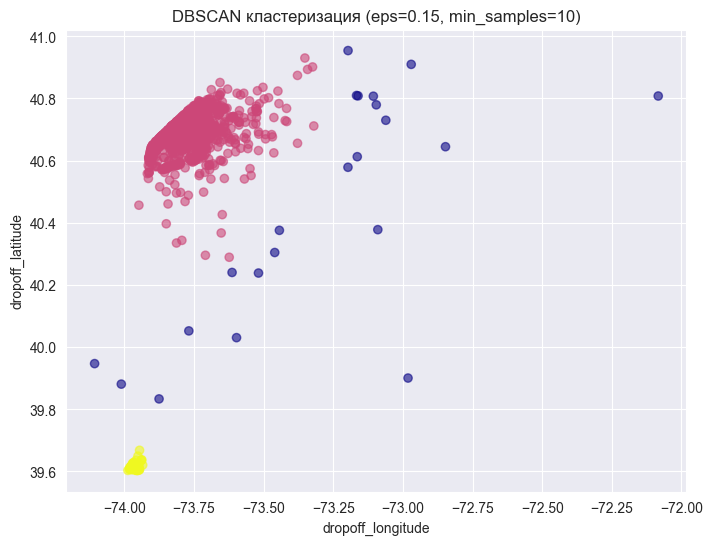

dropoff_latitude центра меньшего кластера: 39.616


In [98]:
from sklearn.cluster import DBSCAN

df_max_fare_cluster = df[df['cluster'] == cluster_with_max_fare]

# Координаты для кластеризации
coords_max_fare = df_max_fare_cluster[['dropoff_latitude', 'dropoff_longitude']]

# DBSCAN с параметрами eps=0.15, min_samples=10
dbscan = DBSCAN(eps=0.15, min_samples=10)
labels = dbscan.fit_predict(coords_max_fare)

# Добавим метки кластеров в DataFrame
df_max_fare_cluster['dbscan_cluster'] = labels

# Визуализация кластеров DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(
    df_max_fare_cluster['dropoff_longitude'],
    df_max_fare_cluster['dropoff_latitude'],
    c=df_max_fare_cluster['dbscan_cluster'],
    cmap='plasma',
    alpha=0.6
)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.title('DBSCAN кластеризация (eps=0.15, min_samples=10)')
plt.show()

# Подсчитаем размеры кластеров
cluster_sizes = df_max_fare_cluster['dbscan_cluster'].value_counts()

# Уберем -1 (это выбросы)
cluster_sizes = cluster_sizes[cluster_sizes.index != -1]

# Найдем меньший кластер
min_cluster_label = cluster_sizes.idxmin()

# Выберем точки меньшего кластера
min_cluster_points = df_max_fare_cluster[df_max_fare_cluster['dbscan_cluster'] == min_cluster_label]

# Центр кластера (среднее арифметическое)
center_lat = min_cluster_points['dropoff_latitude'].mean()
center_long = min_cluster_points['dropoff_longitude'].mean()

# Округляем latitude до тысячных
center_lat_rounded = round(center_lat, 3)

print(f"dropoff_latitude центра меньшего кластера: {center_lat_rounded}")

# Часть 2

## Творческая (но обязательная) часть

В работе мы построили baseline-модель, потом попытались ее улучшить, усложнив пайплайн увеличением, а затем снижением размерности. Но попробовали мы лишь малую часть из всех возможных подходов, а также всего лишь одну модель - решающее дерево.

В этой части задания вам предлагается не ограничивать себя идеями, попробованными выше:
* придумывайте новые признаки
* пробуйте разные кодировки признаков
* снижайте размерность и делайте отбор признаков
* пробуйте разные модели
* комбинируйте подходы

У вас есть знания целого курса для работы над задачей, ни в чем вас не ограничиваем!

Ваша цель - построить модель, дающую наилучший скор $R^2$ на тестовых данных (с фиксированным разбиением на train-test, указанным в коде ноутбука выше).

In [ ]:
# ваш код здесь

### Итоговый отчет

Результаты исследований, проведенных в творческой части задания, оформите в виде отчета. Отчет - это текстовый документ (желательно, google docs - чтобы мы могли при ревью оставлять в нем комментарии), не ноутбук!

В отчете по пунктам должны быть отражены ваши действия при решении задачи:

1) Какие подходы попробовали - перечислить, описать

2) Какие подходы сработали, какие нет

3) Какой пайплайн дал наилучший результат? Какого качества удалось добиться?

4) Интерпретация важности признаков для наилучшего пайплайна. Какие признаки оказались наиболее важны для модели, какие нет? Как вы думаете почему?

Отчет пишется в свободной форме. В отчет можно включать визуализации, если считаете нужным.

Удачи!